In [10]:
# handle bugs in some docker container: 'pip install -e .'  doesn't work 
try:
    import Flamingo
except ModuleNotFoundError:
    import sys 
    sys.path.append('..')
    import Flamingo
lang_encoder_path = "facebook/opt-125m"
tokenizer_path = lang_encoder_path
cache_dir = None 
model_config = dict(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path=lang_encoder_path,
    tokenizer_path=tokenizer_path,
    cross_attn_every_n_layers=1,
    cache_dir = cache_dir,
    lora_tuning=False,
    decoupled=True  
)

import torch
from Flamingo.lora_tuning import create_model_and_transforms 
from Flamingo.models.batchprocessor import DecoupledFlamingoBatchProcessor
from Flamingo.datasets.gtsrb import classes
from Flamingo.config.baseline import dataset_config
from Flamingo.datasets import build_dataset
from Flamingo.inference.vis import show_pred_with_gt
from Flamingo.inference import post_process
import pandas as pd 
import pdb
import re

In [2]:
# build model, image processor and tokenizer
model, image_processor, tokenizer = create_model_and_transforms(
    **model_config
)
print("Load state dict:")
state_dict = torch.load("/root/yunzhi/flamingo_retrieval/retrieval/work_dir/100/weight.pth")
keys1 = model.lang_encoder.gated_cross_attn_layers.load_state_dict(state_dict, strict=False)
keys2 = model.perceiver.load_state_dict(state_dict, strict=False)
dataset = build_dataset(
    dataset_config=dataset_config,
    vis_processor=image_processor,
    tokenizer=tokenizer)
model = model.to(device="cuda:2", dtype=torch.bfloat16)
model.eval()
batch_processor = DecoupledFlamingoBatchProcessor(cast_type='bf16', tokenizer=tokenizer)

Flamingo will use single GPU or CPU

[@rank-1|create Flamingo] create vision_encoder and image_processor from open_clip

[@rank-1|create Flamingo] create text_tokenizer

[@rank-1|create Flamingo] create LLM from  facebook/opt-125m

[@rank-1|create Flamingo] create Flamingo with cross_attn_every_n_layers= 1

[@rank-1|create Flamingo] load checkpoint.pt from huggingface

[@rank-1|create Flamingo] Freeze all parameters

[@rank-1|create Flamingo] LoRa tuning mode:  False

[@rank-1|set requires_grad] No LoRA adaptor, unfrozen the gate cross attention layer

[@rank-1|set requires_grad] unfrozen perceiver layer

Flamingo model initialized with 171MB trainable parameters

Load state dict:


In [11]:
cats = [classes[k] for k in classes]

In [12]:
data = dataset.random_input25()  


In [13]:
with torch.inference_mode():
    output = batch_processor(model=model, batch=data['vision_x'], mode='test',
            text_prompt="<image>Output:", num_beams=3, max_new_tokens=20)
    print("before post process:", output)
    output = post_process(output, cats=cats)
output

before post process: ["Output:Keep right�I'm not sure if you're going to keep right<mask>I'm not", "Output:Speed limit (50km/h)�I'm not sure if I should be driving or", "Output:No entry guiActiveUnI'm not sure what you're doing...\nI'm not sure what you", "Output:No passing veh over 3.5 tons guiActiveUnI'm not sure if I'm allowed to drive", 'Output:Yield', "Output:Turn right ahead�I'm not sure if this is a joke or not, but how do", "Output:End of no passing\x7fI'm going to be passing the end of no passing", 'Output:Children crossing', "Output:Speed limit (70km/h)�I'm not a fan of speed limit (70", "Output:No passing veh over 3.5 tons guiActiveUnI'm not sure if I'm allowed to drive", "Output:Go straight or right guiActiveUnI'm a big fan of the road\x7fI'm a big", 'Output:Speed limit (70km/h)', "Output:Speed limit (80km/h)\x7fI'm not sure if this is a joke or", 'Output:Speed limit (50km/h)', "Output:End of no passing guiActiveUnI'm going to be passing\n\nEnd of no passing�", "Output:Keep

['Keep right',
 'Speed limit (50km/h)',
 'No entry',
 'No passing veh over 3.5 tons',
 'Yield',
 'Turn right ahead',
 'End of no passing',
 'Children crossing',
 'Speed limit (70km/h)',
 'No passing veh over 3.5 tons',
 'Go straight or right',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'Speed limit (50km/h)',
 'End of no passing',
 'Keep left',
 'Speed limit (120km/h)',
 'No passing',
 'Turn left ahead',
 'No passing veh over 3.5 tons',
 'Speed limit (50km/h)',
 'Children crossing',
 'Speed limit (80km/h)',
 'No passing veh over 3.5 tons',
 'Right-of-way at intersection']

In [14]:
# 查看显存占用
torch.cuda.memory_allocated() // (1024 * 1024),torch.cuda.max_memory_allocated() // (1024 * 1024)

(270, 270)

In [15]:
table = pd.DataFrame({
    "pred":output,
    "gt":data['labels']
})
table

,pred,gt
0,Keep right,Keep right
1,Speed limit (50km/h),Speed limit (50km/h)
2,No entry,No entry
3,No passing veh over 3.5 tons,No passing veh over 3.5 tons
4,Yield,Yield
5,Turn right ahead,Turn right ahead
6,End of no passing,End of no passing
7,Children crossing,Children crossing
8,Speed limit (70km/h),Speed limit (70km/h)
9,No passing veh over 3.5 tons,No passing veh over 3.5 tons


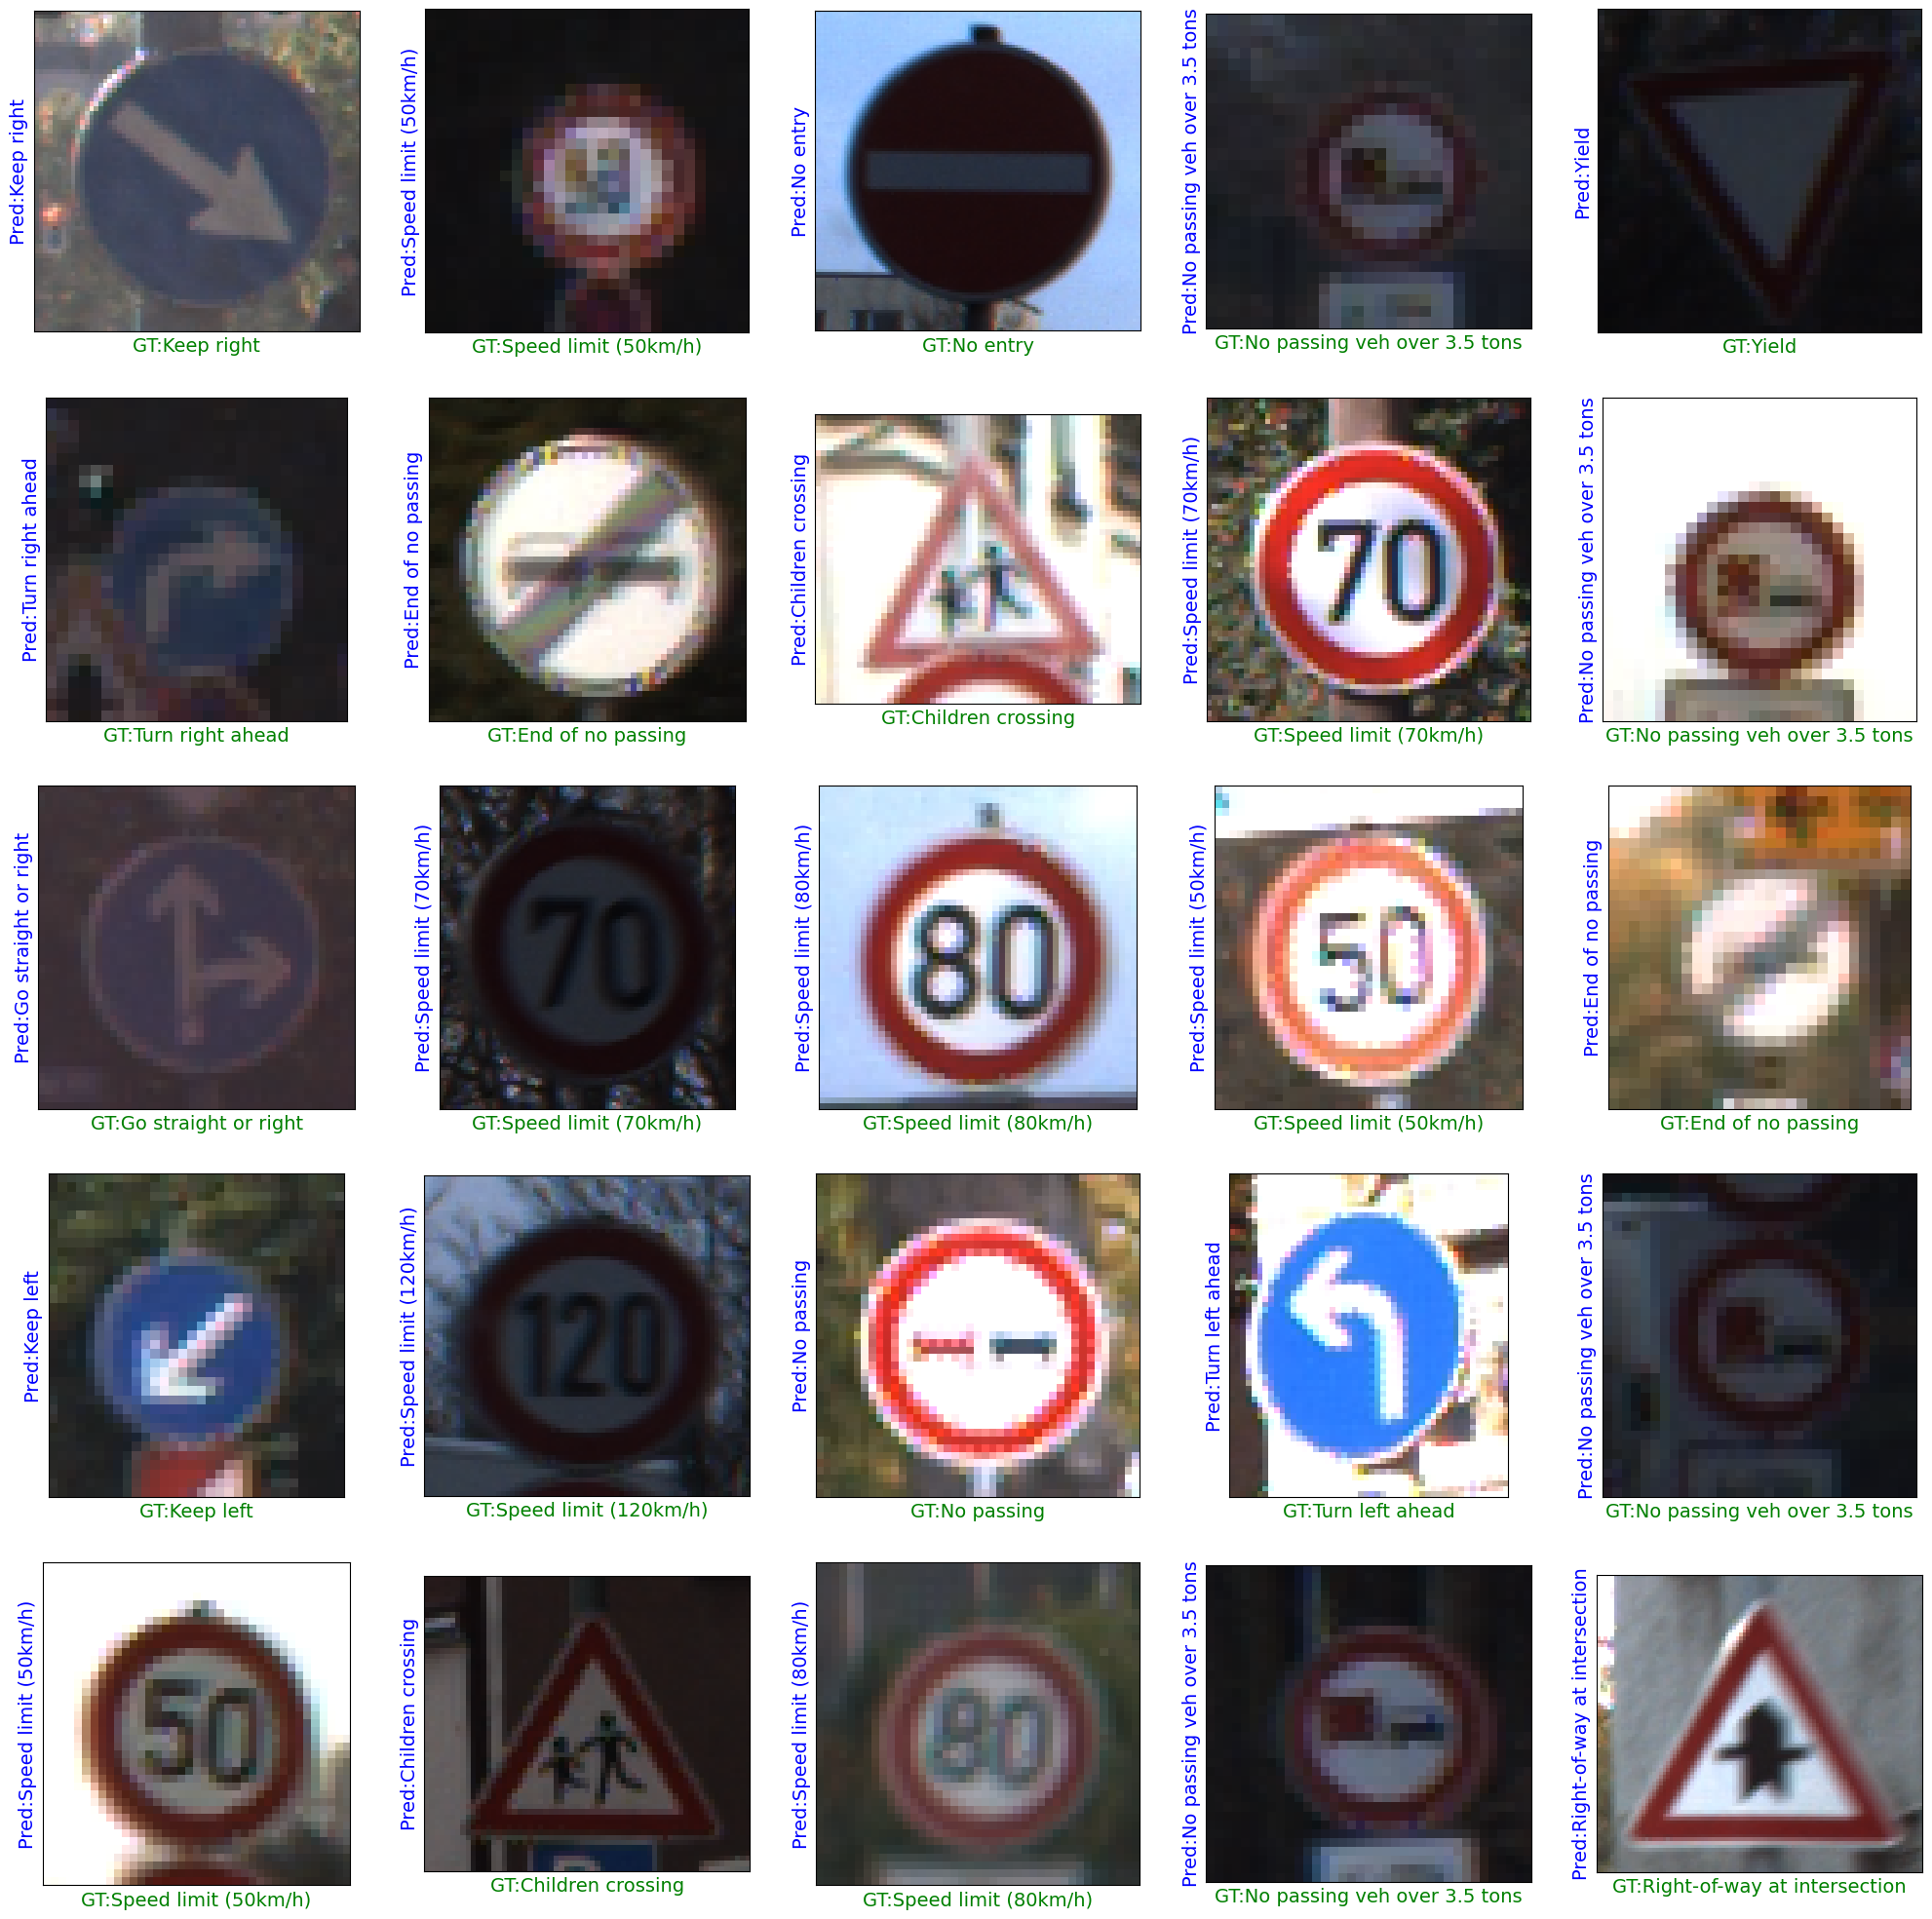

In [16]:
show_pred_with_gt(imgs=data['imgs'], preds=output, gts=data['labels'])

In [17]:
""" 
see training log:
loss is close to 0
"""
!tail -n 20 /root/yunzhi/flamingo_retrieval/retrieval/work_dir/[2024-01-10][22:54:19]PID:64834.log

2024-01-11 06:37:27.622 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:230|409] Dataset: GTSRB, Loss: 8.940696716308594e-07
2024-01-11 06:37:34.273 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:240|409] Dataset: GTSRB, Loss: 6.109476089477539e-07
2024-01-11 06:37:40.628 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:250|409] Dataset: GTSRB, Loss: 6.966292858123779e-07
2024-01-11 06:37:47.428 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:260|409] Dataset: GTSRB, Loss: 2.9616057872772217e-07
2024-01-11 06:37:54.189 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:270|409] Dataset: GTSRB, Loss: 7.636845111846924e-07
2024-01-11 06:38:01.352 | INFO     | Flamingo.runner.deepspeed_runner:info_rank_zero:145 - [rank@0|4][Epoch:100|100][Step:28

In [18]:
# import sentence_transformers
# output[14],data['labels'][1]